In [0]:

import pandas as pd


spark_df_listings= spark.read.table("bronze_listings_tbl")


EDA

Number of NaN values in 'Price' column: 0
+---------+---------+
|price_max|price_min|
+---------+---------+
|     9999|        0|
+---------+---------+



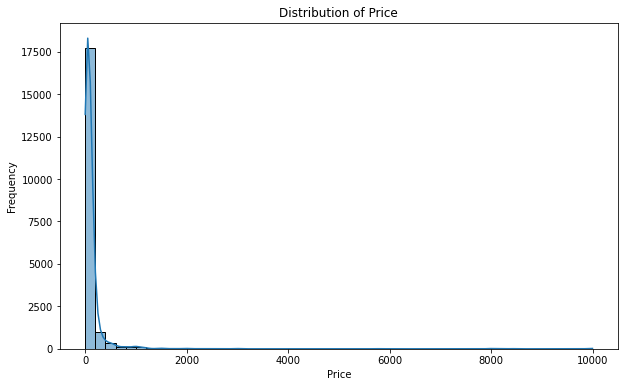

In [0]:
#EDA
#check price distribution


from pyspark.sql.functions import col, isnan, when, count, max, min
from matplotlib import pyplot as plt
import seaborn as sns

nan_count = spark_df_listings.select(
    count(when(col("price").isNull() | isnan(col("price")), "price")).alias("nan_count")
).collect()[0]["nan_count"]

print(f"Number of NaN values in 'Price' column: {nan_count}")

spark_df_listings.select(max(spark_df_listings.price).alias("price_max"), min(spark_df_listings.price).alias("price_min")
    ).show()

min_price = spark_df_listings.agg(min("price")).collect()[0][0]


listings_pd_df = spark_df_listings.select("price").toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(listings_pd_df.price, bins=50, kde=True)
plt.title("Distribution of Price")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()


Average Price by Neighbourhood Group


      neighbourhood_group  average_price
14  San Blas - Canillejas     343.016097
10             Villaverde     180.067797
19              Salamanca     153.238671
18             Arganzuela     140.021739
12              Vicálvaro     138.902778
2               Hortaleza     138.645604
5                  Latina     137.406250
17                 Centro     127.051914
13                 Retiro     124.564759
15                Barajas     119.848837
1                  Tetuán     119.734069
20  Fuencarral - El Pardo     117.907937
4                Chamberí     115.529553
16      Moncloa - Aravaca     114.826715
8               Chamartín     112.744828
11          Ciudad Lineal     105.391371
6                   Usera      93.553571
9               Moratalaz      91.737288
7             Carabanchel      85.324859
3      Puente de Vallecas      78.246353
0       Villa de Vallecas      75.734694


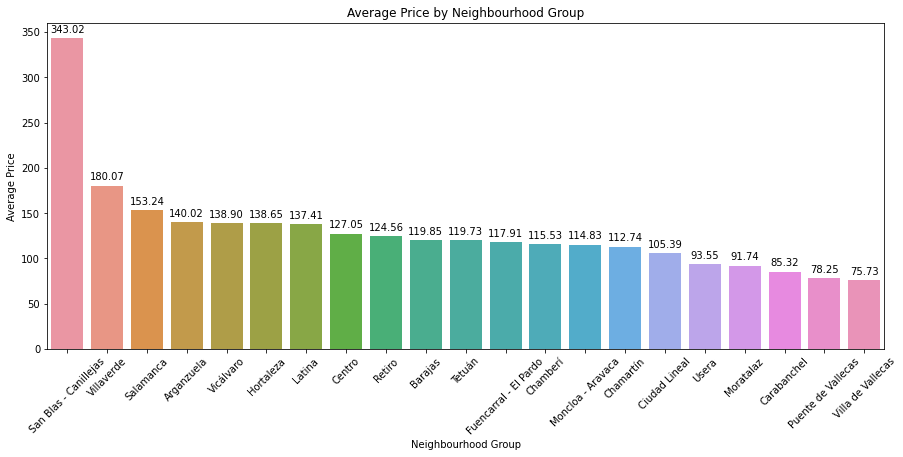

In [0]:
from pyspark.sql.functions import avg, col
average_price_df = spark_df_listings.groupBy("neighbourhood_group").agg(avg(col("Price")).alias("average_price"))

average_price_pd_df = average_price_df.toPandas()

average_price_pd_df = average_price_pd_df.sort_values(by="average_price", ascending=False)

print(average_price_pd_df)

plt.figure(figsize=(15, 6))
barplot = sns.barplot(data=average_price_pd_df, x="neighbourhood_group", y="average_price", order=average_price_pd_df["neighbourhood_group"])

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),  
                     textcoords = 'offset points')

plt.title("Average Price by Neighbourhood Group")
plt.xlabel("Neighbourhood Group")
plt.ylabel("Average Price")
plt.xticks(rotation=45)
plt.show()

Average Price by Room Type

         room_type  average_price
1       Hotel room     343.855422
2  Entire home/apt     161.384568
0      Shared room      83.404255
3     Private room      80.116276


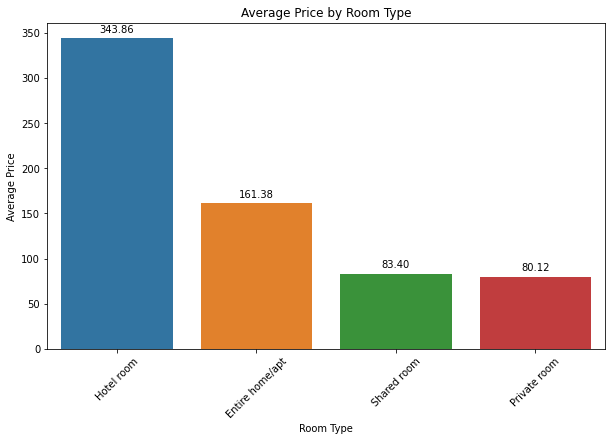

In [0]:
from pyspark.sql.functions import avg, col
average_price_df = spark_df_listings.groupBy("room_type").agg(avg(col("Price")).alias("average_price"))

average_price_pd_df = average_price_df.toPandas()


average_price_pd_df = average_price_pd_df.sort_values(by="average_price", ascending=False)
print(average_price_pd_df)

plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=average_price_pd_df, x="room_type", y="average_price", order=average_price_pd_df["room_type"])

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),  
                     textcoords = 'offset points')

plt.title("Average Price by Room Type")
plt.xlabel("Room Type")
plt.ylabel("Average Price")
plt.xticks(rotation=45)
plt.show()

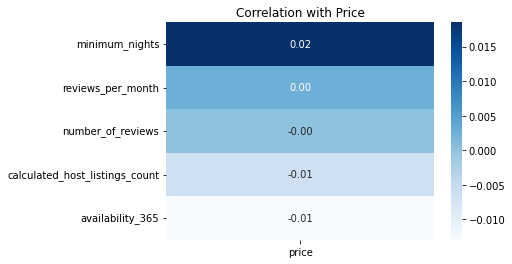

In [0]:
acolumns = [ 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'price']
newdf = spark_df_listings.toPandas()
correlation_matrix = newdf[acolumns].corr()
s=correlation_matrix['price'].drop('price').sort_values(ascending=False)
sns.heatmap(s.to_frame(), annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation with Price')
plt.show()

Data Cleaning


In [0]:
spark_df_listings.dropDuplicates()

Out[6]: DataFrame[id: bigint, name: string, host_id: bigint, host_name: string, neighbourhood_group: string, neighbourhood: string, latitude: double, longitude: double, room_type: string, price: bigint, minimum_nights: bigint, number_of_reviews: bigint, last_review: string, reviews_per_month: double, calculated_host_listings_count: bigint, availability_365: bigint]

In [0]:
columns_to_drop = ["name", "host_name", "host_id", "last_review", "neighbourhood"]
spark_df_listings=spark_df_listings.drop(*columns_to_drop)

In [0]:
# Check for null values
null_counts = {}

for column in spark_df_listings.columns:
    null_count = spark_df_listings.where(col(column).isNull()).count()
    null_counts[column] = null_count

for column, count in null_counts.items():
    print(f"Number of null values in column '{column}': {count}")


Number of null values in column 'id': 0
Number of null values in column 'neighbourhood_group': 0
Number of null values in column 'latitude': 0
Number of null values in column 'longitude': 0
Number of null values in column 'room_type': 0
Number of null values in column 'price': 0
Number of null values in column 'minimum_nights': 0
Number of null values in column 'number_of_reviews': 0
Number of null values in column 'reviews_per_month': 5637
Number of null values in column 'calculated_host_listings_count': 0
Number of null values in column 'availability_365': 0


In [0]:
from pyspark.sql.functions import when
spark_df_listings = spark_df_listings.withColumn("reviews_per_month", when(col("reviews_per_month").isNull(), 0).otherwise(col("reviews_per_month")))


In [0]:
#spark_df_listings.describe().show()
print(spark_df_listings.describe().toPandas().transpose())

                                    0                     1  \
summary                         count                  mean   
id                              19618  2.9122003820012234E7   
neighbourhood_group             19618                  None   
latitude                        19618     40.42098379804263   
longitude                       19618   -3.6940399525945566   
room_type                       19618                  None   
price                           19618    129.27174023855642   
minimum_nights                  19618      6.58619635029055   
number_of_reviews               19618    31.858803139973492   
reviews_per_month               19618     0.802427362626158   
calculated_host_listings_count  19618    10.229177286165767   
availability_365                19618    159.09832806606178   

                                                   2                3  \
summary                                       stddev              min   
id                               1

In [0]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col

def Encode(airbnb):
    for column in ['neighbourhood_group', 'room_type']:
        indexer = StringIndexer(inputCol=column, outputCol=column+"_index")
        airbnb = indexer.fit(airbnb).transform(airbnb).drop(column)
    return airbnb

spark_df_listings= Encode(spark_df_listings)


In [0]:
display(spark_df_listings)

id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_index,room_type_index
11247624,40.41054,-3.7101,35,3,66,1.05,1,105,0.0,0.0
11248487,40.42073,-3.6999,39,1,85,1.37,11,104,0.0,1.0
11248646,40.42073,-3.6999,39,1,94,1.5,11,103,0.0,1.0
11249262,40.42519,-3.70789,69,2,29,0.46,1,0,0.0,0.0
11251920,40.42073,-3.6999,39,1,68,1.12,11,0,0.0,1.0
11251956,40.42073,-3.6999,39,1,135,2.19,11,102,0.0,1.0
11260503,40.42073,-3.6999,293,1,131,2.1,10,337,0.0,0.0
11272211,40.40997,-3.70893,110,1,0,0.0,3,365,0.0,0.0
11275057,40.49216,-3.70627,30,1,106,1.71,1,357,14.0,1.0
11286775,40.41871,-3.7031,81,1,243,3.89,4,102,0.0,0.0


In [0]:

spark_df_listings.write.mode("overwrite").saveAsTable("silver_listings_tbl")